In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

# Investigate Gradients
This notebooks gives basic analysis tools for gradients behavior of different activation functions. As dataset fashion_mnist is used. Its a little harder than mnist and therfore justifies two more convolutional layers, which give the gradients more room to explode or vanish.

### Load the dataset.

In [3]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Investigate the dataset.

In [4]:
# You should make use of the following functions and properties.
# You can access the shape of an array 'arr' with 'arr.shape'.
# You can use 'np.max', 'np.min' to access the maximum or minimum of an array.
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
255
0


**It is always important to understand the format and the count of the data you are dealing with.**  

*How many training/test images does this dataset have?*  
60000 training images, 10000 test images

*Which shape do the images have?*  
28 times 28 pixels

*In which range are the pixel values?*  
grey-scale from 0 to 255

### Visualize the dataset.

In [5]:
print(train_labels[:20])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


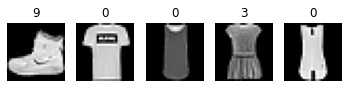

In [6]:
# It can also be helpful to have a proper look at specific samples of a dataset to understand what you are dealing with.
# Plot 5 samples with their corresponding label.

fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

### Build the TensorFlow dataset: Input pipeline
Two different training datasets are build. One without data normalization and one with pixels values centered around zero.

In [7]:
# only take first 500 samples for memory reasons when recording all the gradeints.
# feel free to try more, colab can be a little inconsistent with memory.
# batching also saves memory
train_images = train_images[:500]
train_labels = train_labels[:500]
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_images = train_dataset_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))
# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(1)


# center around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

# zip together input and labels
train_dataset_centered = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset_centered = train_dataset_centered.batch(1)

### Build the model.
A simple CNN Architecture that initializes all convolutional layers with a given activation function. The kerne initializers are default but are given a seed for reproducibility.

In [8]:
 
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self, activation, seed):
        super(Model, self).__init__()
        # Define the layers.
        self.hidden_layers = [
            tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                    activation=activation,
                                    input_shape=(28,28,1),
                                    padding='same',
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                    
                                               ),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=activation,
                                               padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                               ),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                                                activation=activation,
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                                ),
            tf.keras.layers.MaxPool2D(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=activation,
                                               padding='same',
                                               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)

                                                ),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                            activation=activation,
                                            padding='same',
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)

                                            ),
            tf.keras.layers.MaxPool2D(),

            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax,     
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)
                                )

        ]
    @tf.function
    def call(self, x):
        # Define the forward step.
        for layer in self.hidden_layers:
          x = layer(x)
        return x

## Investigate Gradients
Lets first have a look at how gradients actually look

In [9]:
# Perform one training step
loss_function = tf.keras.losses.CategoricalCrossentropy()
# get first batch
iterator = iter(train_dataset)
batch, target = iterator.get_next()

# initialize model
model = Model(activation=tf.keras.activations.relu, seed=1)

# compute the gradeints for the first sample
with tf.GradientTape() as tape:
    prediction = model(batch)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)

   
 


The gradient is a list of tensors of different sizes.
The first entry are the gradients of the weights of the first layer. The second entry are the gradients of the biases of the first layer.
The same pattern repreats for the other layers.

In [10]:
print(type(gradients))
print(len(gradients))
for i in range(len(gradients)):
    print(gradients[i].shape)

<class 'list'>
12
(3, 3, 1, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 128)
(128,)
(128, 10)
(10,)


Gradients for one training sample are of limited significance. How gradients change in the process of training is also relevant.
Lets look a the gradients for one (small) training epoch.


Below are functions for training the model, similar to the ones you already know. The gradient is recorded in addition to the loss.

In [11]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # return gradient in addition to loss
  return loss, gradients 


def train_model(model, train_dataset, loss_function, optimizer, epochs):
    gradients_list = []
    train_losses = []
    running_average_factor = 0.95
    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print('Epoch: __ ' + str(epoch))
        #training
        running_average = 0
        for (input,target) in train_dataset:
            train_loss, gradients = train_step(model, input, target, cross_entropy_loss, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
            gradients_list.append(gradients)
        train_losses.append(running_average)

        
    
    return train_losses, gradients_list


### Training
Lets train multiple models with different activations for one epoch.
The random seeds guarantee the same weight initialization for all models.
Change the global seed for a different weight which are still the same for all models.

In [12]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 1
learning_rate = 0.0001
# reset the global seed after each model initialization to create identical starting weights
# change global seed for different weights
global_seed = 1236
seed = 1

# initialize identical models with different activation functions
tf.random.set_seed(global_seed)
model_relu = Model(activation=tf.keras.activations.relu, seed=seed)
tf.random.set_seed(global_seed)
model_sigmoid = Model(activation=tf.keras.activations.sigmoid, seed=seed)
tf.random.set_seed(global_seed)
model_tanh = Model(activation=tf.keras.activations.tanh, seed=seed)

# train the models for one epoch
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

_, gradients_relu = train_model(model_relu, train_dataset, cross_entropy_loss, optimizer, num_epochs)
_, gradients_sigmoid = train_model(model_sigmoid, train_dataset, cross_entropy_loss, optimizer, num_epochs)
_, gradients_tanh = train_model(model_tanh, train_dataset, cross_entropy_loss, optimizer, num_epochs)

# again but with centered input data
tf.random.set_seed(global_seed)
model_relu = Model(activation=tf.keras.activations.relu, seed=seed)
tf.random.set_seed(global_seed)
model_sigmoid = Model(activation=tf.keras.activations.sigmoid, seed=seed)
tf.random.set_seed(global_seed)
model_tanh = Model(activation=tf.keras.activations.tanh, seed=seed)

_, gradients_relu_c = train_model(model_relu, train_dataset_centered, cross_entropy_loss, optimizer, num_epochs)
_, gradients_sigmoid_c = train_model(model_sigmoid, train_dataset_centered,  cross_entropy_loss, optimizer, num_epochs)
_, gradients_tanh_c = train_model(model_tanh, train_dataset_centered, cross_entropy_loss, optimizer, num_epochs)

Epoch: __ 0
Epoch: __ 0
Epoch: __ 0
Epoch: __ 0
Epoch: __ 0
Epoch: __ 0


### Gradient Analysis
The recorded gradients are a nested list. For each batch there is  list containing the gradeints for the layers like above.
The stack_gradient function combines the gradients for each layer across batches.
The reduce_gradients function uses a reduce operator on the gradients(mean, min etc.) and returns the results, seperated into weights and biases.



In [13]:
def stack_gradients(gradients):
    '''stacks the gradient tensors across batches for each layer'''
    gradients_tensorlist = [[] for i in range(len(gradients[0]))]
    for batch in gradients:
        for j in range(len(batch)):
            gradients_tensorlist[j].append(batch[j])
    gradients_tensorlist = [tf.stack(layer) for layer in gradients_tensorlist]      
    return gradients_tensorlist  

def count_nonzero(gradients):
    ''' For each layer counts weights and biases gradeints which are nonzero. 
    Also collects indices where gradients are zero'''
    nonzero_weights_count = []
    zero_weights = []
    nonzero_biases_count = []
    zero_biases = []
    for i, layer in enumerate(gradients):
        if i%2 == 0:
            #counts nonzero gradients
            nonzero_weights_count.append(tf.math.count_nonzero(layer))
            # indices where gradient is zero
            zero_weights.append(tf.where(layer == 0))
        else:
            nonzero_biases_count.append(tf.math.count_nonzero(layer))
            zero_biases.append(tf.where(layer == 0))
    return nonzero_weights_count, nonzero_biases_count, zero_weights, zero_biases


def reduce_gradients(gradients, reduce_func=tf.reduce_mean, axis=None):
    ''' reduces abstract gradients of weights and biases 
        for each layer according to the operator
    '''
    reduce_weight_gradients = []
    reduce_bias_gradients = []
     
    for i, layer in enumerate(gradients):
        if i%2 == 0:
             
            reduce_weight_gradients.append(reduce_func(tf.abs(layer), axis=axis))
        else: 
            reduce_bias_gradients.append(reduce_func(tf.abs(layer)))
 
    return reduce_weight_gradients, reduce_bias_gradients

In [14]:
# stack gradients across batches
gradients_relu_stacked = stack_gradients(gradients_relu)
gradients_sigmoid_stacked = stack_gradients(gradients_sigmoid)
gradients_tanh_stacked = stack_gradients(gradients_tanh)

gradients_relu_c_stacked = stack_gradients(gradients_relu_c)
gradients_sigmoid_c_stacked = stack_gradients(gradients_sigmoid_c)
gradients_tanh_c_stacked = stack_gradients(gradients_tanh_c)

# get average gradients for layers
average_weight_relu, average_bias_relu= reduce_gradients(gradients_relu_stacked)
average_weight_sigmoid, average_bias_sigmoid = reduce_gradients(gradients_sigmoid_stacked)
average_weight_tanh, average_bias_tanh = reduce_gradients(gradients_tanh_stacked)

average_weight_relu_c, average_bias_relu_c= reduce_gradients(gradients_relu_c_stacked)
average_weight_sigmoid_c, average_bias_sigmoid_c= reduce_gradients(gradients_sigmoid_c_stacked)
average_weight_tanh_c, average_bias_tanh_c = reduce_gradients(gradients_tanh_c_stacked)

# get max gradients
max_weight_relu, max_bias_relu = reduce_gradients(gradients_relu_stacked, tf.reduce_max)
max_weight_sigmoid, max_bias_sigmoid = reduce_gradients(gradients_sigmoid_stacked, tf.reduce_max)
max_weight_tanh, max_bias_tanh = reduce_gradients(gradients_tanh_stacked, tf.reduce_max)

max_weight_relu_c, max_bias_relu_c = reduce_gradients(gradients_relu_c_stacked, tf.reduce_max)
max_weight_sigmoid_c, max_bias_sigmoid_c = reduce_gradients(gradients_sigmoid_c_stacked, tf.reduce_max)
max_weight_tanh_c, max_bias_tanh_c = reduce_gradients(gradients_tanh_c_stacked, tf.reduce_max)
 
 

### Plot Activations

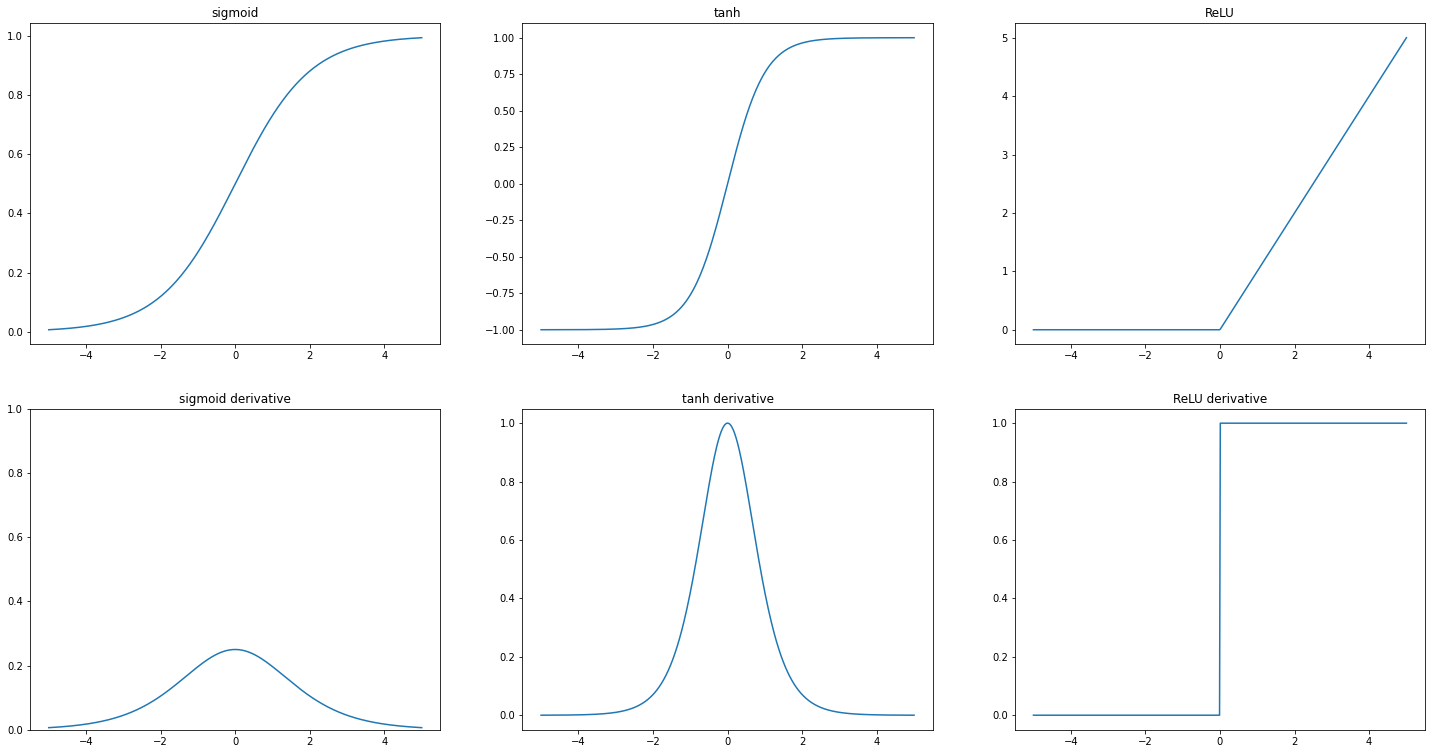

In [15]:
x = np.linspace(-5, 5, 500)

plt.figure(figsize=(25, 13))
plt.subplot(2,3,1)
plt.title('sigmoid')
plt.plot(x, tf.keras.activations.sigmoid(x))
plt.subplot(2,3,2)
plt.title('tanh')
plt.plot(x, tf.keras.activations.tanh(x))
plt.subplot(2,3,3)
plt.title('ReLU')
plt.plot(x, tf.keras.activations.relu(x))
plt.subplot(2,3,4)
plt.title('sigmoid derivative')
plt.ylim(0,1)
plt.plot(x, tf.keras.activations.sigmoid(x) * (1-tf.keras.activations.sigmoid(x)))
plt.subplot(2,3,5)
plt.title('tanh derivative')
plt.plot(x, 1-np.square(tf.keras.activations.tanh(x)))
plt.subplot(2,3,6)
plt.title('ReLU derivative')
plt.plot(x, np.piecewise(x, [x < 0, x >= 0], [0, 1]))

plt.show()

### Plot Gradients

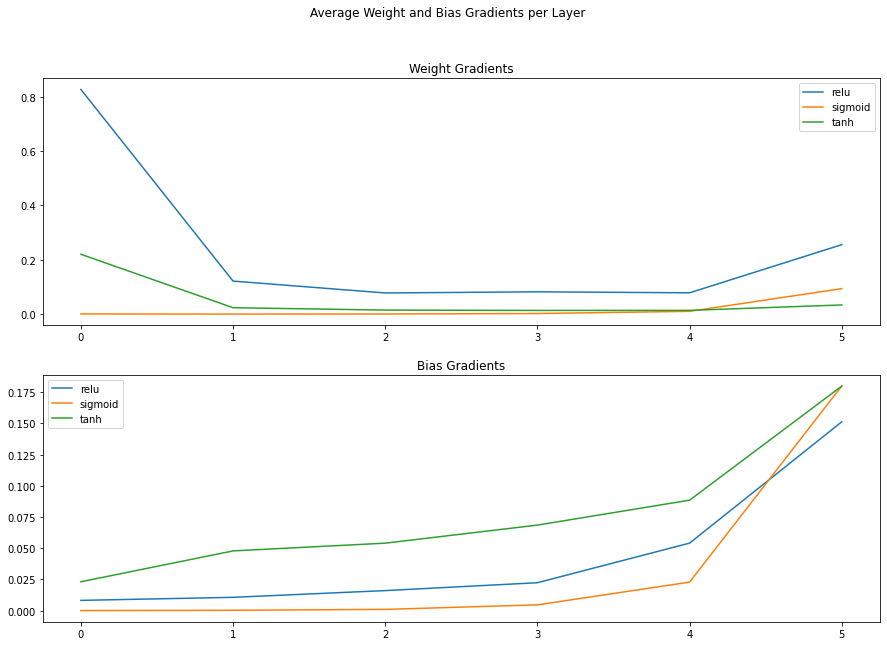

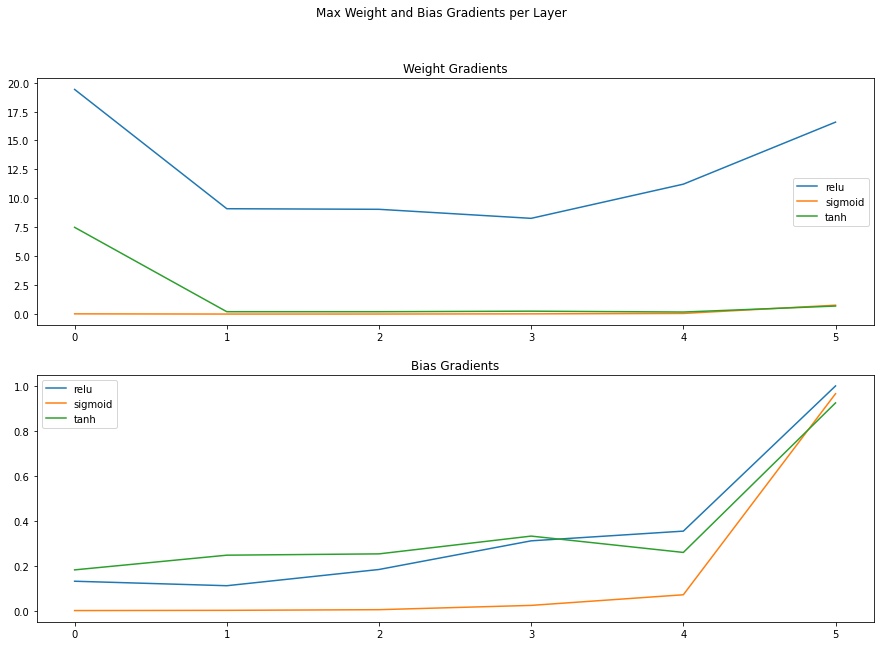

In [16]:
# Plot average gradients for not centered input data
fig = plt.figure(figsize=(15,10))
fig.suptitle('Average Weight and Bias Gradients per Layer')
a = fig.add_subplot(2,1,1)
a.set_title('Weight Gradients')
line1, = a.plot(average_weight_relu[:])
line2, = a.plot(average_weight_sigmoid[:])
line3, = a.plot(average_weight_tanh[:])
a.legend(('relu', 'sigmoid', 'tanh'))

b = fig.add_subplot(2,1,2)
b.set_title('Bias Gradients')
line1, = b.plot(average_bias_relu[:])
line2, = b.plot(average_bias_sigmoid[:])
line3, = b.plot(average_bias_tanh[:])
b.legend(('relu', 'sigmoid', 'tanh'))
plt.show()

# Plot max gradients for not centered input data
fig = plt.figure(figsize=(15,10))
fig.suptitle('Max Weight and Bias Gradients per Layer')
a = fig.add_subplot(2,1,1)
a.set_title('Weight Gradients')
line1, = a.plot(max_weight_relu)
line2, = a.plot(max_weight_sigmoid)
line3, = a.plot(max_weight_tanh)

a.legend(('relu', 'sigmoid', 'tanh'))
b = fig.add_subplot(2,1,2)
b.set_title('Bias Gradients')
line1, = b.plot(max_bias_relu)
line2, = b.plot(max_bias_sigmoid)
line3, = b.plot(max_bias_tanh)
b.legend(('relu', 'sigmoid', 'tanh'))
plt.show()

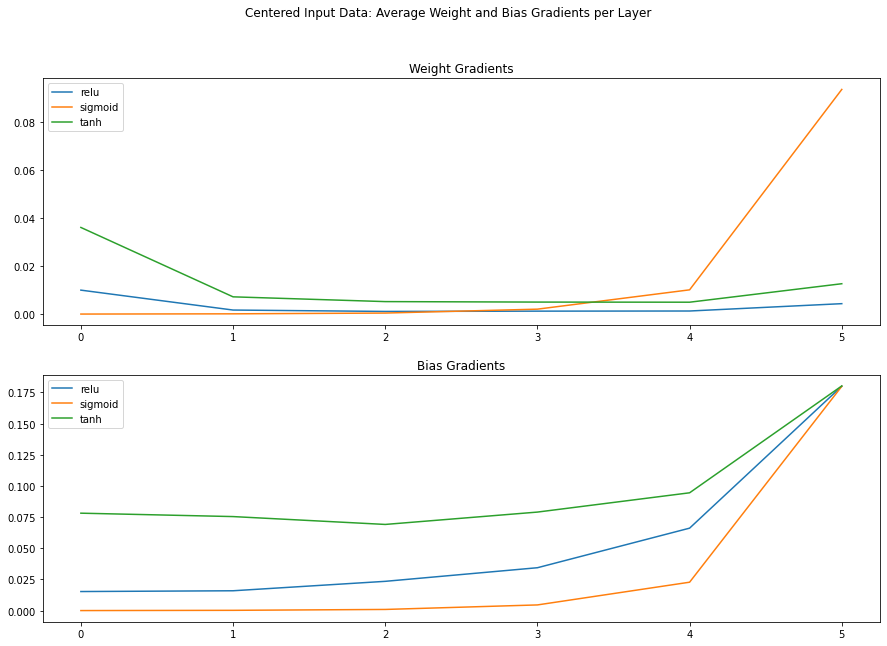

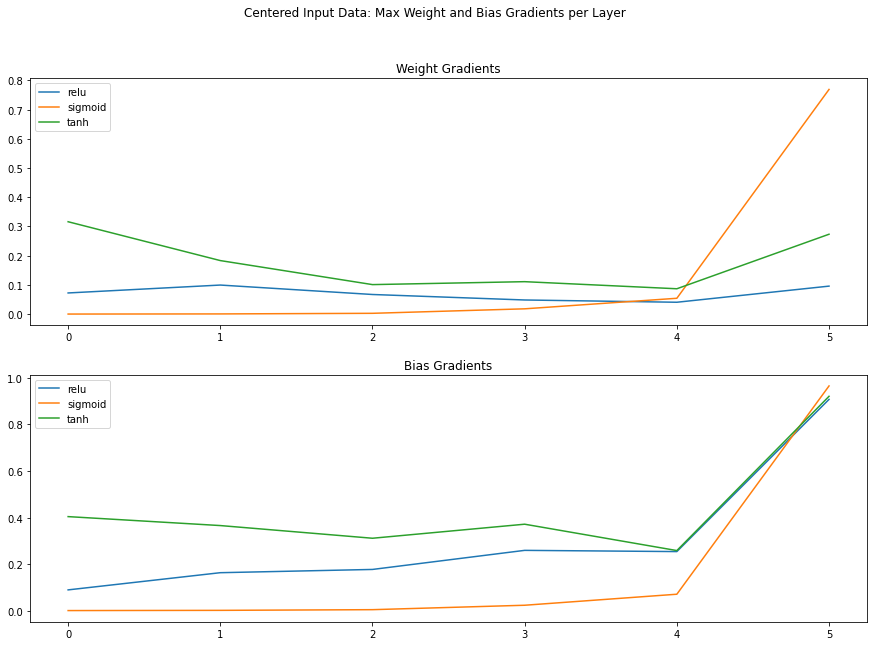

In [17]:
# Plot average gradients for centered input data

fig = plt.figure(figsize=(15,10))
fig.suptitle('Centered Input Data: Average Weight and Bias Gradients per Layer')
a = fig.add_subplot(2,1,1)
a.set_title('Weight Gradients')
line1, = a.plot(average_weight_relu_c[:])
line2, = a.plot(average_weight_sigmoid_c[:])
line3, = a.plot(average_weight_tanh_c[:])
a.legend(('relu', 'sigmoid', 'tanh'))

b = fig.add_subplot(2,1,2)
b.set_title('Bias Gradients')
line1, = b.plot(average_bias_relu_c[:])
line2, = b.plot(average_bias_sigmoid_c[:])
line3, = b.plot(average_bias_tanh_c[:])
b.legend(('relu', 'sigmoid', 'tanh'))
plt.show() 
# Plot max gradients for centered input data
fig = plt.figure(figsize=(15,10))
fig.suptitle('Centered Input Data: Max Weight and Bias Gradients per Layer')
a = fig.add_subplot(2,1,1)
a.set_title('Weight Gradients')
line1, = a.plot(max_weight_relu_c)
line2, = a.plot(max_weight_sigmoid_c)
line3, = a.plot(max_weight_tanh_c)

a.legend(('relu', 'sigmoid', 'tanh'))
b = fig.add_subplot(2,1,2)
b.set_title('Bias Gradients')
line1, = b.plot(max_bias_relu_c)
line2, = b.plot(max_bias_sigmoid_c)
line3, = b.plot(max_bias_tanh_c)
b.legend(('relu', 'sigmoid', 'tanh'))
plt.show()

This is just a very basic analysis of gradient behavior. Feel free to investigate further. Here are some ideas

**Further Questions:**
- What influence does batch size have?
- How does model architecture influence gradients (deeper or shallower networks)
- Convergence behavior 
    - Here only the effects on one epoch were visualized
    - How do different activations influence convergence?
- Try other activation functions
- Can you spot dying Relus with gradient analysis?
    - have a look at the count_nonzero function
- Try something besides average and max

You can post your modified notebook if you made some discoveries!